# import and root path definition

In [ ]:
import re
import sys
from pathlib import Path
from collections import Counter
from datetime import datetime, time

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
ROOT = Path('/home/jun0/Projects/emart24')
sys.path.append(str(ROOT))
print(sys.path)

# 분류 체계 확장

In [ ]:
# 카테고리 데이터
category = pd.read_excel(ROOT / 'data/category.xlsx')
category.columns = ['KAN_CODE', '전체분류', '현재분류명', '상품예시']

# 상품 마스터 데이터
item = pd.read_csv(ROOT / 'data/prep/02.설명이추가된 상품마스터_20210325.csv', sep='|', dtype=str)
item['점포발주입수수량'] = item['점포발주입수수량'].fillna(0)
item['공급가'] = item['공급가'].fillna(0).apply(lambda x: round(float(x)))
item['매가'] = item['매가'].fillna(0)
item['점포유통기한일수'] = item['점포유통기한일수'].fillna(0)
item = item.astype({'점포발주입수수량': int, '공급가': int, '매가': int, '점포유통기한일수': int})

# shapes
category.shape, item.shape

In [ ]:
category.head(2)

In [ ]:
contained = item.fillna('').apply(lambda row: (row['GDS_SLPNT_DSCRT'] in row['GDS_DSCRT']) & bool(row['GDS_DSCRT']) & bool(row['GDS_SLPNT_DSCRT']), axis=1)
contained_reverse = item.fillna('').apply(lambda row: (row['GDS_DSCRT'] in row['GDS_SLPNT_DSCRT']) & bool(row['GDS_DSCRT']) & bool(row['GDS_SLPNT_DSCRT']), axis=1)
only_dscrt = item['GDS_DSCRT'].isna() & ~item['GDS_SLPNT_DSCRT'].isna()
only_slpnt = ~item['GDS_DSCRT'].isna() & item['GDS_SLPNT_DSCRT'].isna()

In [ ]:
item[item.fillna('').apply(lambda row: (row['GDS_SLPNT_DSCRT'] != row['GDS_DSCRT']) & (row['GDS_DSCRT'] in row['GDS_SLPNT_DSCRT']) & bool(row['GDS_DSCRT']) & bool(row['GDS_SLPNT_DSCRT']), axis=1)][['상품명', 'GDS_DSCRT', 'GDS_SLPNT_DSCRT']]

In [ ]:
item[item['GDS_DSCRT'].isna() & item['GDS_SLPNT_DSCRT'].isna()].shape

In [ ]:
item[item.fillna('').apply(lambda row: bool(row['GDS_DSCRT']) & bool(row['GDS_SLPNT_DSCRT']), axis=1)].shape

In [ ]:
3624 / 13869

In [ ]:
item[contained][['상품명', 'GDS_DSCRT', 'GDS_SLPNT_DSCRT']].shape

In [ ]:
item[only_dscrt][['상품명', 'GDS_DSCRT', 'GDS_SLPNT_DSCRT']].shape

In [ ]:
item[only_slpnt][['상품명', 'GDS_DSCRT', 'GDS_SLPNT_DSCRT']].shape

In [ ]:
item[contained_reverse][['상품명', 'GDS_DSCRT', 'GDS_SLPNT_DSCRT']].shape

In [ ]:
item[~contained][['상품명', 'GDS_DSCRT', 'GDS_SLPNT_DSCRT']].shape

In [ ]:
temp = pd.read_csv(ROOT / 'data/prep/02.설명이추가된 상품마스터_20210325.csv', sep='|', dtype=str)
temp[temp['점포발주입수수량'].isna() | temp['공급가'].isna() | temp['매가'].isna() | temp['점포유통기한일수'].isna()][['점포발주입수수량', '공급가', '매가', '점포유통기한일수']]

In [ ]:
# 전체 카테고리
all_category = []
temp = pd.DataFrame(category['전체분류'].apply(lambda row: row.split('>')).tolist())
for col in temp.columns:
    all_category += temp[col].unique().tolist()
unique_category = set(all_category)
len(all_category), len(unique_category)

In [ ]:
# 전체분류 마지막 항목과 현재분류명 일치하지 않는 케이스
category[~(category['전체분류'].apply(lambda row: row.split('>')[-1]) == category['현재분류명'])]

In [ ]:
# 전처리해야할 대상들
category[category['전체분류'].duplicated(keep=False)]

In [ ]:
# category의 아이템
category_item = [x for lst in category['상품예시'].apply(lambda row: [x.strip() for x in row.split(',')]).tolist() for x in lst]
# '' 제거
category_item = list(filter(lambda x: x != '', category_item))
category_item_unique = set(category_item)
category_item_unique = list(category_item_unique)[1:]
len(category_item), len(category_item_unique)

In [ ]:
# unique 한 상품명
item_unique_bool = ~item['상품명'].duplicated()
# 분류가 겹치는 아이템
overlap = item_unique_bool & (item['대분류명'].isin(unique_category) | item['중분류명'].isin(unique_category) | item['소분류명'].isin(unique_category))
# 단순 일치하는 상품명
exact_match_bool = item_unique_bool & item['상품명'].isin(category_item_unique)
# 상품명에 포함된 상품예시
contain_bool = item_unique_bool & item['상품명'].apply(lambda x: bool([i for i in category_item_unique if i in x]))
item['상품예시'] = item['상품명'].apply(lambda x: [i for i in category_item_unique if i in x])
item['카테고리'] = ''

item[overlap].shape, item[exact_match_bool].shape, item[contain_bool].shape, item[overlap | contain_bool].shape

In [ ]:
item[item['상품예시'].apply(lambda row: bool([x for x in row if len(x) > 1]))][['PLU_CD', '상품명', '상품예시', '카테고리']].sample(100)

In [ ]:
temp_item_list = ['징', '오일', '클렌징오일', '참기름', '수세미', '시가', '주방가위', '가위']
temp_bool = category['상품예시'].apply(lambda row: any([x.strip() in temp_item_list for x in row.split(',')]))
category[temp_bool].head(10)

In [ ]:
# 상품 설명 보기
item[['GDS_DSCRT', 'GDS_SLPNT_DSCRT']].drop_duplicates().values.tolist()

# 거래 데이터

In [ ]:
# 거래데이터
# emart24 = ROOT / 'data/emart24Data'
# f = emart24 / '001_TRAN/IFAI_001_TRAN_00115.txt'
# f = emart24 / '007_DAYQTY/IFAI_007_DAYQTY_00115.txt'
# f = emart24 / '008_STRPUR/IFAI_008_STRPUR_00115.txt'
# f = emart24 / '009_STRORD/IFAI_009_STRORD_00115.txt'
# f = emart24 / 'IFAI_100_RCMQTY_03193.txt'
files = (ROOT / 'data/emart24Data/001_TRAN').glob('*.txt')
transaction = pd.DataFrame()
for i, file in enumerate(files):
    transaction = pd.concat([transaction, pd.read_csv(file, sep='|', low_memory=False)], 0)

# 파일 수, 데이터 건수
i + 1, transaction.shape

In [ ]:
transaction.iloc[:, :10]

In [ ]:
# 상품 분류 데이터
item1 = pd.read_excel(ROOT / 'data/prep/분류명겹침_매핑.xlsx')
item2 = pd.read_csv(ROOT / 'data/prep/item_category_matched_with_example.csv')
item1.shape, item2.shape

In [ ]:
items = pd.concat([item1, item2], 0)[['PLU_CD', '상품명', '전체분류', '현재분류명', '상품예시']]
items['상품명'].unique().shape, items['PLU_CD'].unique().shape, items.shape

In [ ]:
items.sample(5)

In [ ]:
transaction['ITEM_NM'].unique().shape, transaction['PLU_CD'].unique().shape

In [ ]:
trans_filtered = transaction[transaction['PLU_CD'].isin(items['PLU_CD'].unique())]
trans_filtered.shape

In [ ]:
trans_filtered['PLU_CD'].unique().shape, trans_filtered['ITEM_NM'].unique().shape, 

In [ ]:
trans_filtered.iloc[:100, :].merge(items, how='left', on='PLU_CD')[['PLU_CD', 'ITEM_NM', '상품명', '전체분류', '현재분류명', '상품예시']]

In [ ]:
trans_filtered = trans_filtered.merge(items, how='left', on='PLU_CD')

In [ ]:
trans_filtered.keys()

In [ ]:
# save as csv files
for g, df in trans_filtered.groupby('YMD'):
    # print(g, df.shape)
    df.to_csv(ROOT / f'data/prep/transactions/{g}.csv', index=False)

# Start from reading filtered transactions

In [1]:
import re
import sys
from pathlib import Path
from collections import Counter
from datetime import datetime, time

import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
ROOT = Path('/home/jun0/Projects/emart24')
sys.path.append(str(ROOT))
print(sys.path)

['/home/yoonho/Desktop/emart24_codes_local/LYH', '/home/yoonho/.vscode-server/extensions/ms-toolsai.jupyter-2021.8.2041215044/pythonFiles', '/home/yoonho/.vscode-server/extensions/ms-toolsai.jupyter-2021.8.2041215044/pythonFiles/lib/python', '/home/yoonho/anaconda3/envs/models/lib/python37.zip', '/home/yoonho/anaconda3/envs/models/lib/python3.7', '/home/yoonho/anaconda3/envs/models/lib/python3.7/lib-dynload', '', '/home/yoonho/anaconda3/envs/models/lib/python3.7/site-packages', '/home/yoonho/anaconda3/envs/models/lib/python3.7/site-packages/IPython/extensions', '/home/yoonho/.ipython', '/home/jun0/Projects/emart24']


In [2]:
# read items
item1 = pd.read_excel(ROOT / 'data/prep/분류명겹침_매핑.xlsx', engine='openpyxl')
item2 = pd.read_csv(ROOT / 'data/prep/item_category_matched_with_example.csv')
items = pd.concat([item1, item2], 0)[['PLU_CD', '상품명', '전체분류', '현재분류명', '상품예시']]
items['상품명'].unique().shape, items['PLU_CD'].unique().shape, items.shape

/home/yoonho/anaconda3/envs/models/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (35) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


((23120,), (25248,), (38353, 5))

In [3]:
# read from file
from tqdm import tqdm
trans_filtered = pd.DataFrame()
counter = 0
for f in tqdm(sorted((ROOT / 'data/prep/transactions').glob('*.csv'))):
    if counter >= 30:   # remove counter to read total file
        break
    # print(g, df.shape)
    trans_filtered = pd.concat([trans_filtered, pd.read_csv(f)])
    counter+=1
trans_filtered.shape

  4%|▍         | 30/762 [01:32<37:35,  3.08s/it]  


(2777394, 100)

In [4]:
# 참고 코드
trans_filtered['YMD'] = trans_filtered['SYS_YMDHMS'].apply(lambda row: row // 1000000)
trans_filtered['time'] = trans_filtered['SYS_YMDHMS'].apply(lambda row: f'{row % 1000000:06d}')
trans_filtered['hour'] = trans_filtered['SYS_YMDHMS'].apply(lambda row: f'{(row % 1000000) // 10000:02d}')
#trans_filtered.head()

In [ ]:
## 참고 코드
#temp_df = trans_filtered['YMD'].value_counts().reset_index()
#temp_df['index'] = temp_df['index'].apply(lambda row: datetime.strptime(str(row), '%Y%m%d'))
#fig = px.bar(temp_df, x='index', y='YMD')
#fig.show()
#temp_df = trans_filtered['time'].value_counts().reset_index().sort_values('index')
## temp_df['index'] = temp_df['index'].apply(lambda row: time(hour=int(row[:2]), minute=int(row[2:4]), second=int(row[4:])).strftime('%H:%M:%S'))
#temp_df['index'] = temp_df['index'].apply(lambda row: time(hour=int(row[:2]), minute=int(row[2:4])).strftime('%H:%M:%S'))
#fig = px.bar(temp_df, x='index', y='time')
#fig.show()

In [5]:
category_large = list(set([a.split('>')[0] for a in trans_filtered['전체분류']]))
print(category_large)
print("대분류 수: ",len(category_large))

['신선식품', '기타상품', '교육/문화용품', '가구/인테리어', '전문스포츠/레저', '패션잡화', '일상용품', '의류', '의약품/의료기기', '디지털/가전', '가공식품']
대분류 수:  11


In [6]:
temp_category_large = pd.DataFrame([a.split('>')[0] for a in trans_filtered['전체분류']],columns=['대분류'])
hour_data = pd.DataFrame(list(trans_filtered['hour']), columns=['시간'])
our_interest = pd.concat([temp_category_large, hour_data], axis=1)
our_interest.head()


,대분류,시간
0,일상용품,00
1,일상용품,00
2,가공식품,00
3,가공식품,00
4,가공식품,00


In [7]:
hour_statistics = pd.DataFrame(columns=['대분류','00','01','02','03','04','05','06', '07', '08', '09', '10','11','12','13','14','15','16', '17', '18', '19', '20', '21', '22', '23' ])
for category_index in range(len(category_large)):
    temp_c_i = our_interest[our_interest['대분류']==category_large[category_index]]
    counted=[0 for k in range(24)]
    for i in range(24):
        counted[i] = sum(temp_c_i['시간']==f'{i:02d}')
    hour_statistics.loc[len(hour_statistics)] = [category_large[category_index]]+counted

In [8]:
hour_statistics

,대분류,00,01,02,03,04,05,06,07,08,...,14,15,16,17,18,19,20,21,22,23
0,신선식품,14662,6471,3177,1858,1590,1813,4801,12443,23419,...,23853,27750,28607,28841,33893,35286,35262,35977,36576,26866
1,기타상품,0,0,0,0,0,0,0,0,0,...,0,3,3,1,2,2,1,3,1,0
2,교육/문화용품,1036,471,259,158,135,220,587,1889,3070,...,3482,3554,3846,4033,4266,4083,3711,3335,3140,1931
3,가구/인테리어,133,42,36,19,23,53,104,275,407,...,293,335,320,415,491,418,396,313,301,214
4,전문스포츠/레저,1868,903,506,342,269,439,1612,3422,4493,...,3716,3902,4060,4578,5923,5605,5464,5169,4671,3398
5,패션잡화,221,96,73,49,25,48,72,182,299,...,489,487,386,388,435,524,572,576,586,396
6,일상용품,23760,10904,5818,3766,3697,5404,14821,33247,52368,...,52766,55196,53547,51404,58779,59493,57690,59108,57851,43294
7,의류,0,0,0,0,0,0,1,1,0,...,0,1,1,0,2,0,2,7,0,0
8,의약품/의료기기,863,403,211,138,128,88,181,325,526,...,1042,1025,1096,1272,1857,1860,1694,1600,1712,1374
9,디지털/가전,52,15,13,8,8,5,14,43,79,...,111,105,108,98,155,112,114,114,93,69


신선식품


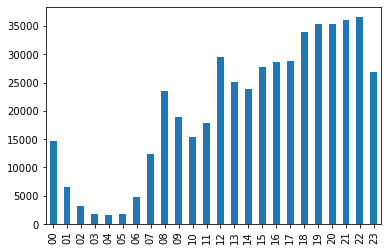




기타상품


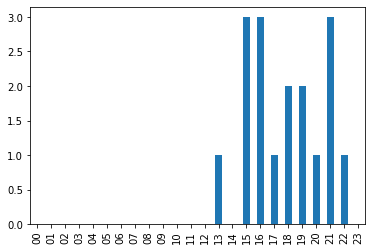




교육/문화용품


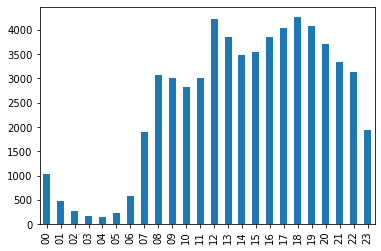




가구/인테리어


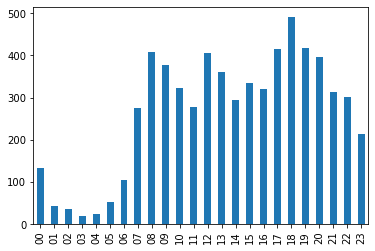




전문스포츠/레저


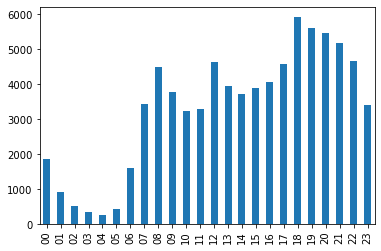




패션잡화


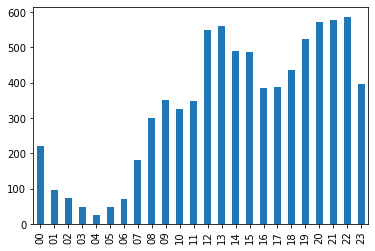




일상용품


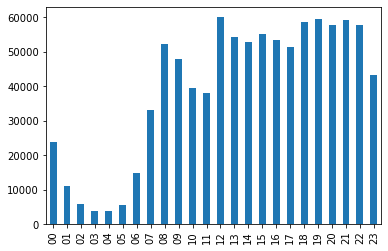




의류


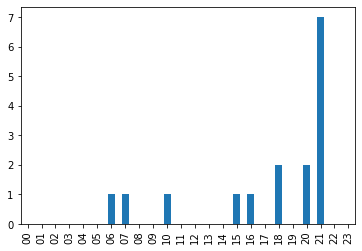




의약품/의료기기


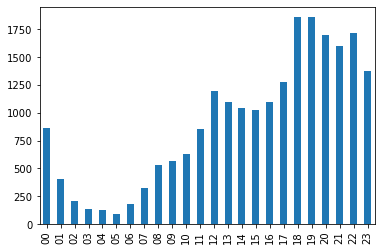




디지털/가전


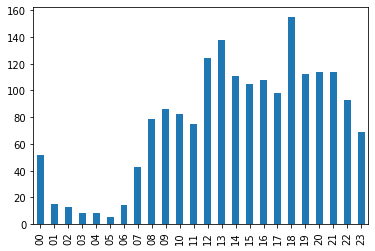




가공식품


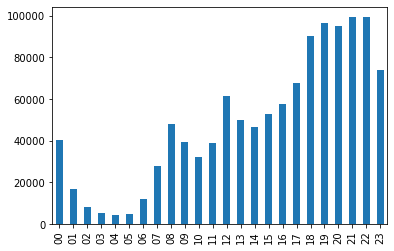

In [9]:
import matplotlib.pyplot as plt
for i in range(len(hour_statistics)):
    temp = hour_statistics.iloc[i,1:]
    temp.plot(kind='bar')
    print(hour_statistics.iloc[i,0])
    plt.show()
    print("\n\n")